In [4]:
from pathlib import Path
import io
import json
import random

import matplotlib.pyplot as plt
import networkx as nx

import spacy.util
from spacy.en import English
from spacy.gold import GoldParse
from spacy.syntax.util import Config
from spacy.syntax.arc_eager import ArcEager
from spacy.syntax.parser import Parser
from spacy.scorer import Scorer
from spacy.tagger import Tagger
from spacy.pipeline import DependencyParser
from spacy.syntax.nonproj import PseudoProjectivity
from spacy.language import Language
from spacy.tokens import Doc
from spacy.vocab import Vocab
from spacy.symbols import PUNCT, SYM, VERB, DET, ADJ, NOUN, ADP, INTJ, X, PART, PRON, ADV, PROPN, CONJ
from spacy.attrs import POS

def prepare_environment(path_to_model):
    
    model_path = Path(path_to_model)
    if not model_path.exists():
        model_path.mkdir()
        
    if not (model_path / "deps").exists():
        (model_path / "deps").mkdir()
        
    if not (model_path / "pos").exists():
        (model_path / "pos").mkdir()             
            
def _parse_line(line):
    pieces = line.split()
    id_ = int(pieces[0].split('_')[-1])
    word = pieces[1]
    pos = pieces[4]
    head_idx = int(pieces[6])-1
    label = pieces[7]
    return word, pos, head_idx, label


def read_conll_from_path(path):
    """Read a standard CoNLL/MALT-style format"""
    with io.open(path, 'r', encoding='utf8') as file_:
        sents = []
        for sent_str in file_.read().strip().split('\n\n'):
            ids = []
            words = []
            heads = []
            labels = []
            tags = []
            for i, line in enumerate(sent_str.split('\n')):
                word, pos_string, head_idx, label = _parse_line(line)
                words.append(word)
                if head_idx < 0:
                    head_idx = i
                ids.append(i)
                heads.append(head_idx)
                labels.append(label)
                tags.append(pos_string)
            text = ' '.join(words)
            annot = (ids, words, tags, heads, labels, ['O'] * len(ids))
            sents.append((None, [(annot, [])]))
    return sents

def process_data(data):
    return PseudoProjectivity.preprocess_training_data(data)
    
    
def write_config_file(model_dir, actions, features):
    model_path = Path(model_dir)
    with (model_path / 'deps' / 'config.json').open('wb') as file_:
        file_.write(
            json.dumps(
                {'pseudoprojective': True, 'labels': actions, 'features': features}).encode('utf8'))
def get_label_set(gold_tuples):
    left_labels, right_labels = [set()] * 2
    for _, sents in gold_tuples:
        for annot_tuples, _ in sents:
            _, words, deps, heads, thing1, thing2 = annot_tuples
            for i, (head, dep) in enumerate(zip(heads, deps)):
                if i < head:
                    left_labels.add(dep)
                elif i > head:
                    right_labels.add(dep)   
    return sorted(left_labels), sorted(right_labels)


def create_language_model(model_dir, features, train_sents, actions):
    
    left_labels, right_labels = get_label_set(train_sents)
    
    tag_map = English.Defaults.tag_map
    additional_tags = {
        u'~':{POS:X},
        u'@':{POS:X},
        u'D':{POS: DET},
        u'A':{POS: ADJ}, 
        u'N':{POS: NOUN},  
        u'P':{POS: ADP},      
        u'!':{POS: INTJ},  
        u'#':{POS: X},   
        u',':{POS: PUNCT},    
        u'S':{POS: NOUN, u'Poss': u'yes'}, 
        u'Z':{POS: PROPN, u'Poss': u'yes'},
        u'O':{POS: PRON},
        u'R':{POS: ADV},        
        u'V':{POS:VERB},
        u'E':{POS: X},
        u'G':{POS: X},        
        u'^':{POS: PROPN},   
        u'&':{POS: CONJ},        
        u'L':{POS: VERB},  
        u'U':{POS: X},
        u'X':{POS: ADJ},
        u'T':{POS: PART},
        u'Y':{POS: VERB},
        u'M':{POS: VERB, u'NounType': u'prop'},
    }
    tag_map.update(additional_tags)
    
    vocab = Vocab(lex_attr_getters=Language.Defaults.lex_attr_getters, tag_map=tag_map)
    tagger = Tagger(vocab, tag_map=tag_map)
    parser = DependencyParser(vocab, actions = actions, features = features, left_labels=left_labels, right_labels=right_labels)    
    nlp = Language(vocab=vocab, tagger = tagger, parser = parser)
    
    return nlp
    
          


def score_model(nlp, gold_docs, verbose=False):
    scorer = Scorer()
    for _, gold_doc in gold_docs:
        for (ids, words, pos, dep_idx, dep_relations, entities), _ in gold_doc:
            doc = Doc(nlp.vocab, words=words)
            nlp.tagger(doc)
            nlp.parser(doc)
            PseudoProjectivity.deprojectivize(doc)
            gold = GoldParse(doc, tags=pos, heads=dep_idx, deps=dep_relations)
            scorer.score(doc, gold, verbose=verbose)
    return scorer


def train(nlp, training_sents,testing_sents, n_iter = 20):

    print("Itn.\tPOS% \tUAS% \tLAS%")
    for itn in range(n_iter): 
        loss = 0
        for _, sents in training_sents:
            for (ids, words, pos, dep_idx, dep_relations, entities), _ in sents:
                doc = nlp.tokenizer.tokens_from_list(words)
                gold = GoldParse(doc, annot_tuples=None, words=words, tags=pos, heads=dep_idx, deps=dep_relations, make_projective=False)                          
                nlp.tagger(doc)
                nlp.parser.update(doc, gold) 
                doc = nlp.tokenizer.tokens_from_list(words)
                nlp.tagger.update(doc, gold)
        scorer = score_model(nlp, testing_sents)

        random.shuffle(training_sents)
        print('%d:\t%d\t%.3f\t%.3f\t' % (itn, scorer.tags_acc, scorer.uas,scorer.las))
    return nlp

In [2]:
def train_tagger_and_parser_model(model_dir, path_to_training_data, path_to_testing_data):
    prepare_environment(model_dir)
    train_data = read_conll_from_path(path_to_training_data)
    train_sents = process_data(train_data)

    test_data = read_conll_from_path(path_to_testing_data)
    test_sents = process_data(test_data)


    actions = ArcEager.get_actions(gold_parses=train_sents)
    features = Language.Defaults.parser_features
    write_config_file(model_dir, actions, features)

    nlp = create_language_model(model_dir, features, train_sents, actions)
    nlp = train(nlp, train_sents, test_sents)
    return nlp

In [3]:
#model_dir = '/home/vagrant/testmodel/en-1.1.0/'
model_dir = 'custom_model/'
path_to_training_data = '/cust/nlp-research/projects/TweeboParser/Tweebank/Train_Test_Splited/train'
path_to_testing_data = '/cust/nlp-research/projects/TweeboParser/Tweebank/Train_Test_Splited/test'

nlp = train_tagger_and_parser_model(model_dir, path_to_training_data, path_to_testing_data)

Itn.	POS Accuracy 	UAS 	LAS%
0:	71	66.467	63.262	
1:	69	64.706	61.782	
2:	77	70.306	66.291	
3:	77	72.279	68.792	
4:	78	73.864	69.496	
5:	80	74.815	71.680	
6:	79	70.588	66.397	
7:	80	74.956	72.702	
8:	80	76.294	71.962	
9:	81	75.590	72.596	
10:	80	75.907	71.856	
11:	81	76.823	73.230	
12:	81	75.801	72.314	
13:	82	76.013	72.737	
14:	82	78.056	75.132	
15:	81	75.062	71.680	
16:	80	75.977	72.772	
17:	81	77.809	74.287	
18:	81	77.175	73.829	
19:	80	76.365	73.512	


In [7]:
tweet = u'RT: @MikeyMike I went to the #KanyeWest concert too!'
doc = nlp(tweet)
map(lambda x: (x.orth_, x.pos_, x.tag_, x.dep_), doc)

[(u'RT', u'X', u'~', u'ROOT'),
 (u':', u'PUNCT', u',', u'ROOT'),
 (u'@MikeyMike', u'X', u'@', u'ROOT'),
 (u'I', u'PRON', u'O', u'_'),
 (u'went', u'VERB', u'V', u'ROOT'),
 (u'to', u'ADP', u'P', u'_'),
 (u'the', u'DET', u'D', u'_'),
 (u'#', u'PROPN', u'^', u'_'),
 (u'KanyeWest', u'PROPN', u'^', u'_'),
 (u'concert', u'VERB', u'V', u'_'),
 (u'too', u'ADV', u'R', u'_'),
 (u'!', u'PUNCT', u',', u'ROOT')]

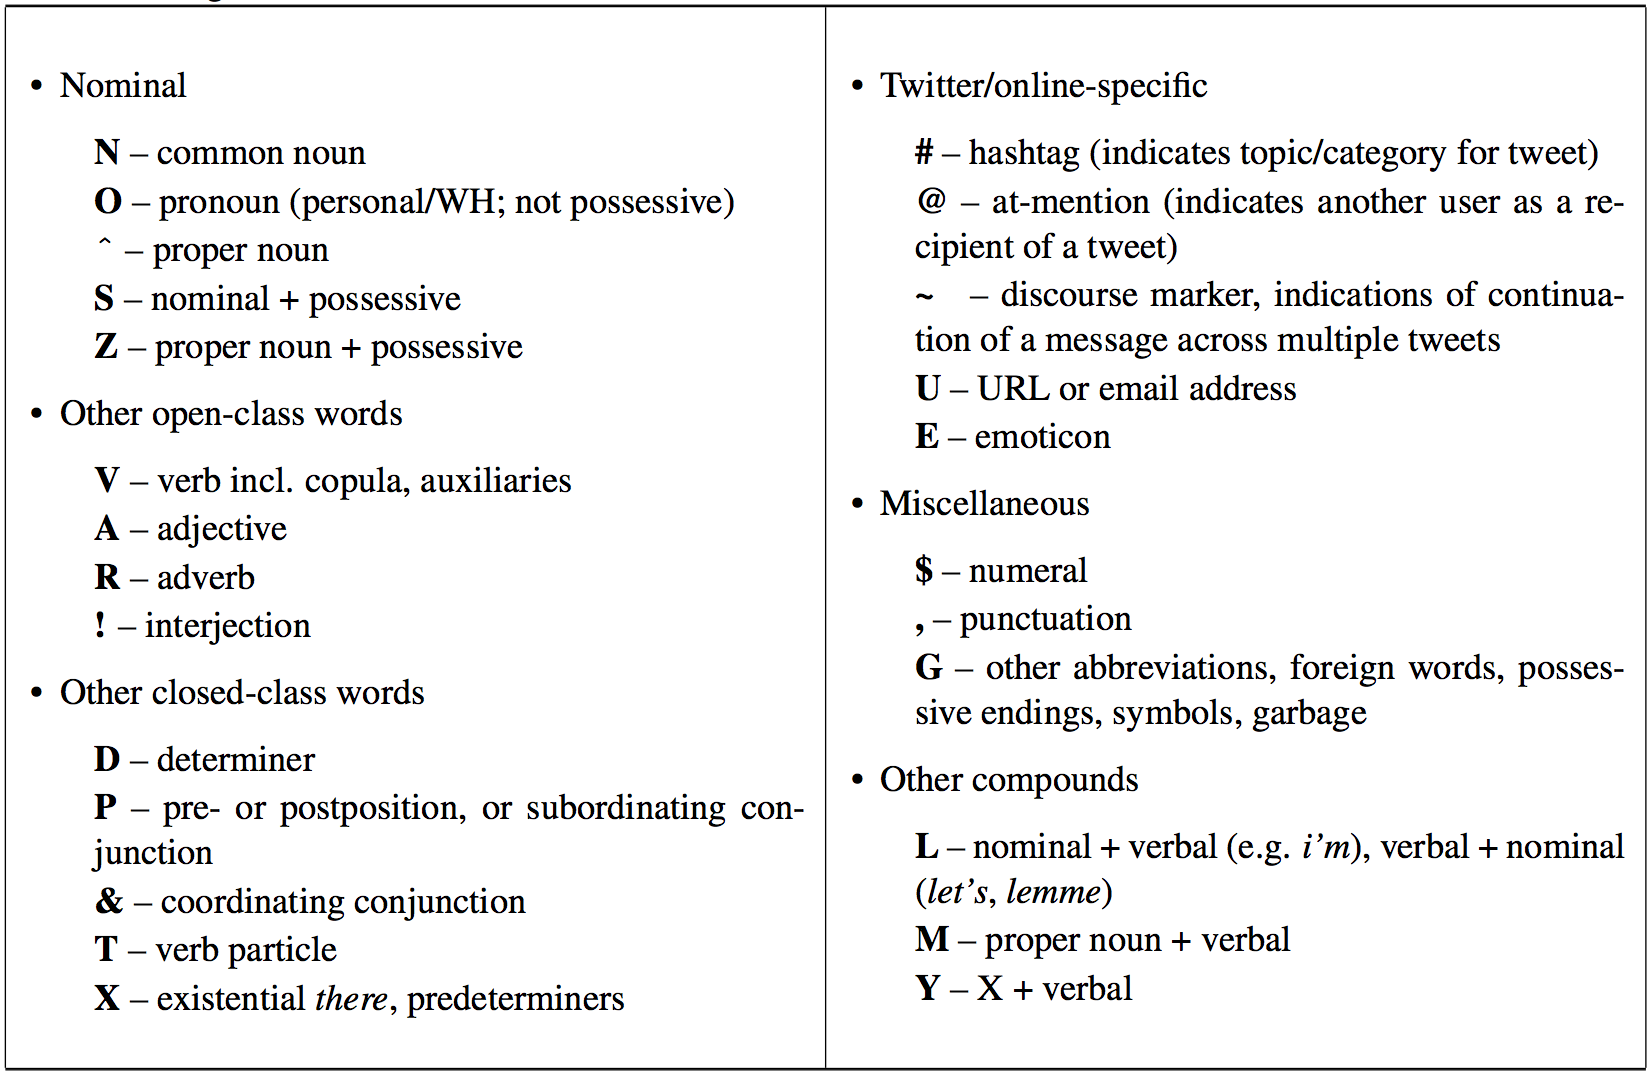

In [21]:
from IPython.display import Image
Image('tag_definitions.png')

In [64]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 7)

class DependencyGraph(object):
    """
    Create networkx object holding parse. Plot the graph
    """
    
    
    def __init__(self, doc):
        """
        Parameters
        ----------
        spacy_sentence (spacy.span.span.Span):
            Span of a sentence or phrase in spacy
        """
        self.doc = doc
        self.graphs = [self.sentToGraph(i) for i in doc.sents]
        self.graph = nx.disjoint_union_all(self.graphs)
        self.edges = {key: g.graph.edge[key] for key in g.graph.edge if g.graph.edge[key] }        
        
        
    
    def sentToGraph(self, sent):
        
        def recurseOnGraph(token, graph):
            for child in token.children:
                graph.add_node(child.i, {'word':child.orth_,'tag':child.tag_})
                graph.add_edge(token.i, child.i, {'dep':child.dep_})
                recurseOnGraph(child, graph)
            return graph
        
        graph = nx.DiGraph()
        root = sent.root
        graph.add_node(root.i, {'word':root.orth_,'tag':root.tag_})        
        return recurseOnGraph(root, graph)   
    
    def plot_graph(self, with_labels=True,arrows=False, font_size=18, node_size=2000, **kwargs):
        f, ax = plt.subplots(1)
        edge_labels = edge_labels=dict([((u,v,),d['dep']) for u,v,d in self.graph.edges(data=True)])
        #edge_labels = edge_labels=dict([((u,v,),d['dep']) for u,v,d in self.edges(data=True)])
        node_labels = {i:g.graph.node[i]['word'] for i in g.graph.node.keys()}

        pos = nx.graphviz_layout(self.graph,prog='dot')
        
        nx.draw(self.graph,
                pos,
                labels = node_labels,
                with_labels = with_labels,
                arrows=arrows, 
                font_size=font_size, 
                node_size=node_size, 
                ax=ax, 
                **kwargs
        )
        
        try:
            nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels,ax=ax, font_size=14)
        except:
            return pos
        
        ax.set_title(self.doc.text_with_ws, size = 22)
        return pos
        return ax

In [ ]:
html = """

<h3> Steps to training a custom parser </h3>

<table style="width:100%;font-style:normal;font-size:14px;font-weight:lighter;">
  <tr>
    <th>Step</th>
    <th>Summary</th> 
    <th>Our Implementation</th>
    <th>Details</th>
  </tr>
  <tr>
    <th>1</th>
    <th>Setup environment for new model</th> 
    <th><span class="code">build_environment(model_path, copy_english=True)</span></th>
    <th></th>
  </tr>
  
  <tr>
    <th>2</th>
    <th>Get training data</th> 
    <th><span class="code">get_training_data(model_path, copy_english=True)</span></th>
    <th>twitter data from Tweebo project, which is in standard conll format</th>
  </tr>  
</table>
<style>
  table: {
    fontFamily: '"AvenirNext", sans-serif',
    color: dsColors.greyBlue500,
  },
  tableElement: {
    borderBottom: `1px solid ${dsColors.grey800}`,
    padding: '29px 12px',
    fontSize: 13,
    lineHeight: 1.1,
    textAlign: 'left',
  },
  tableHeader: {
    borderBottom: `2px solid ${dsColors.greyBlue800}`,
    padding: '5px 12px',
    textAlign: 'left',
    textTransform: 'uppercase',
    fontSize: 12,
    lineHeight: 1.2
  },
  tableHeaderRow: {
  },
  tableHead: {
  },
  tableRow: {
  },
  hoverRowStyle: {
    backgroundColor: dsColors.grey300
  },
  tableRowZebraStripe: {
    backgroundColor: dsColors.grey200,
  }
}
</style>
"""

from IPython.display import HTML
HTML(html)